## The PDE example

The PDE equation is:

$$\frac{\partial \phi}{\partial t}=-u\frac{\partial \phi}{\partial x}$$

With the initial value:
$$\phi_0 = \phi(x,0)$$

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import time

# tf.compat.v1.disable_eager_execution()

# 1. Build model

## Model
https://weikaiwei.com/tf/tensorflow-2-mnist-2/

In [35]:
class solve_PDE_Model():
    def __init__(self, loss_calculator):
        self.loss_calculator = loss_calculator
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
        self.metrics = tf.keras.metrics.Mean(0.001)

        inputs = tf.keras.Input(shape=(2,), name="inputs")
        x = tf.keras.layers.Dense(units=20, activation=tf.nn.sigmoid, name='layer1')(inputs)
        x = tf.keras.layers.Dense(units=20, activation=tf.nn.sigmoid, name='layer2')(x)
        x = tf.keras.layers.Dense(units=20, activation=tf.nn.sigmoid, name='layer3')(x)
        x = tf.keras.layers.Dense(units=20, activation=tf.nn.sigmoid, name='layer4')(x)
        x = tf.keras.layers.Dense(units=20, activation=tf.nn.sigmoid, name='layer5')(x)
        outputs = tf.keras.layers.Dense(units=1, name='output')(x)
    
        self.model = tf.keras.Model(inputs=inputs, outputs=outputs)
            

    def predict(self, x_data, t_data):
        print("Start prediction")
        input_data = tf.stack([tf.reshape(x_data, [-1]), tf.reshape(t_data, [-1])], axis=1)
        return self.model(input_data)

    def train(self, x_data, t_data, epochs):
        print("Start training")
        self.metrics.reset_states()

        for epoch in range(epochs):
            self.train_epoch(x_data, t_data)

            if(epoch%500 == 0):
                print("Epoch {0}, Loss {1}".format(epoch, self.metrics.result()))

    @tf.function
    def train_epoch(self, x_data, t_data):
        with tf.GradientTape() as tape:
            x_data_reshape = tf.reshape(x_data, [-1])
            t_data_reshape = tf.reshape(t_data, [-1])
            input_data = tf.stack([x_data_reshape, t_data_reshape], axis=1)

            # Run forward
            phi = self.model(input_data)
            # Compute the loss value
            # loss = self.loss_calculator.loss(x_data_reshape, t_data_reshape, phi)
            loss = self.loss_calculator.loss(input_data, phi)


        # Update metrics
        self.metrics.update_state(loss)

        # Compute gradients
        trainable_vars = self.model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        #Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))


## [Loss function](https://www.tensorflow.org/guide/keras/train_and_evaluate#custom_losses)

In [36]:
class PDE_Loss():
    def __init__(self, phi_init, u, regularization_factor=0.1):
        self.phi_init = phi_init
        self.u = u

    def loss(self, inputs, phi):
    # def loss(self, x_data, t_data, phi):

        gradient = tf.gradients(phi, inputs)[0]
        phi_t, phi_x = tf.unstack(gradient,axis=1)

        phi_t = tf.reshape(phi_t, [phi_t.shape[0],1])
        phi_x = tf.reshape(phi_x, [phi_x.shape[0],1])
        
        # phi_t = tf.gradients(phi, t_data)[0]
        # phi_x = tf.gradients(phi, x_data)[0]

        # phi_t = tf.reshape(phi_t, [phi_t.shape[0],1])
        # phi_x = tf.reshape(phi_x, [phi_x.shape[0],1])
        
        governing_Eq = phi_t+self.u+phi_x
        
        init_size = self.phi_init.shape[0]

        number_of_time_step = governing_Eq.shape[0] / init_size
        
        loss = tf.reduce_mean(tf.square(phi[:init_size]-self.phi_init)) 

        for one_time_step in range(1, int(number_of_time_step)):
                    
            loss += tf.reduce_sum(tf.square(
                # governing_Eq in loss   
                governing_Eq[one_time_step*init_size+1:(one_time_step+1)*init_size-1]
            ))
    
            loss += tf.reduce_mean(tf.square(
                 # bc in loss   
                (phi[one_time_step*init_size][0]-1.0) 
            ))
        
            loss += tf.reduce_mean(tf.square(
                 # bc in loss   
                (phi[(one_time_step+1)*init_size-1][0]-1.0)
            ))
                

        return loss
    


In [37]:
lx = 2
nx = 20
dx = lx / (nx-1)

lt = 0.05
nt = 3
dt = lt / (nt-1)

u = 1      #assume wavespeed of u = 1

x_line = tf.linspace(0.0, lx, nx, name="x")
t_line = tf.linspace(0.0, lt, nt, name="t")
x_init = tf.identity(x_line, name="x_init")
x, t = tf.meshgrid(x_line, t_line)


# sine wave init
np_phi_init = np.ones(nx)
sine_wave = np.linspace(0,2*np.pi, int(1.5 / dx + 1) - int(.5 / dx) )
np_phi_init[int(.5 / dx):int(1.5 / dx + 1)] += np.sin(sine_wave)
phi_init = tf.convert_to_tensor(np_phi_init, dtype=tf.float32, name="phi_init")

loss_calculator = PDE_Loss(phi_init,u)
myModel = solve_PDE_Model(loss_calculator)
myModel.train(x, t, 100000)

Start training
Epoch 0, Loss 41.411643981933594
Epoch 500, Loss 3.652949571609497
Epoch 1000, Loss 1.954392910003662
Epoch 1500, Loss 1.3873307704925537
Epoch 2000, Loss 1.1035912036895752
Epoch 2500, Loss 0.933259904384613
Epoch 3000, Loss 0.819665253162384
Epoch 3500, Loss 0.7385017275810242
Epoch 4000, Loss 0.6776068210601807
Epoch 4500, Loss 0.6302484273910522
Epoch 5000, Loss 0.5923548936843872
Epoch 5500, Loss 0.5613503456115723
Epoch 6000, Loss 0.5355242490768433
Epoch 6500, Loss 0.5136682987213135
Epoch 7000, Loss 0.49493828415870667
Epoch 7500, Loss 0.4786994755268097
Epoch 8000, Loss 0.46449020504951477
Epoch 8500, Loss 0.4519529640674591
Epoch 9000, Loss 0.4408116042613983
Epoch 9500, Loss 0.43084287643432617
Epoch 10000, Loss 0.4218668043613434
Epoch 10500, Loss 0.41374295949935913
Epoch 11000, Loss 0.40636101365089417
Epoch 11500, Loss 0.3996228575706482
Epoch 12000, Loss 0.39344003796577454
Epoch 12500, Loss 0.3877573311328888
Epoch 13000, Loss 0.38251155614852905
Epoch 1

In [31]:
result = myModel.predict(x, t)
print(result)

Start prediction
tf.Tensor(
[[1.0258739 ]
 [1.0154371 ]
 [1.0065564 ]
 [0.99923074]
 [0.9934386 ]
 [0.98913896]
 [0.9862726 ]
 [0.9847647 ]
 [0.984524  ]
 [0.9854466 ]
 [0.98741627]
 [0.99030733]
 [0.9939866 ]
 [0.99831617]
 [1.0031564 ]
 [1.008368  ]
 [1.0138159 ]
 [1.0193713 ]
 [1.0249139 ]
 [1.0303338 ]
 [1.0037642 ]
 [0.99292386]
 [0.98365057]
 [0.9759431 ]
 [0.9697821 ]
 [0.96512866]
 [0.9619261 ]
 [0.96010137]
 [0.9595665 ]
 [0.96022034]
 [0.96194947]
 [0.96463084]
 [0.96813333]
 [0.9723209 ]
 [0.9770545 ]
 [0.98219526]
 [0.9876077 ]
 [0.99316144]
 [0.99873435]
 [1.004214  ]
 [0.9816706 ]
 [0.97044396]
 [0.9607918 ]
 [0.95271516]
 [0.9461955 ]
 [0.94119525]
 [0.93766016]
 [0.9355198 ]
 [0.9346893 ]
 [0.93506986]
 [0.9365512 ]
 [0.93901336]
 [0.9423274 ]
 [0.9463594 ]
 [0.9509715 ]
 [0.95602596]
 [0.9613868 ]
 [0.96692264]
 [0.97251   ]
 [0.9780338 ]], shape=(60, 1), dtype=float32)


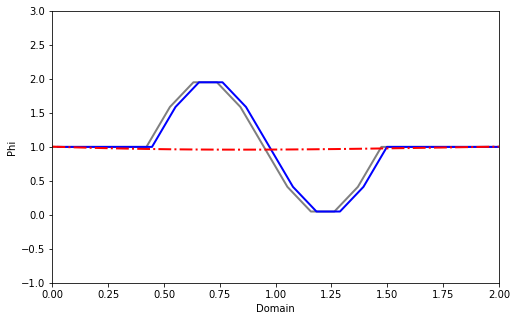

In [32]:
import matplotlib.pyplot as plt

%matplotlib inline

# create a figure and axes
fig = plt.figure(figsize=(8,5))
ax1 = plt.subplot(1,1,1)   

# set up the subplots as needed
ax1.set_xlim((0, 2))            
ax1.set_ylim((-1, 3))
ax1.set_xlabel('Domain')
ax1.set_ylabel('Phi')

# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
n=1
txt_title = ax1.set_title('')
line1, = ax1.plot(tf.reshape(x_line, [-1]), phi_init, 'gray', lw=2)
line1, = ax1.plot(tf.reshape(x_line, [-1])+dt*n*u, phi_init, 'b', lw=2)
line2, = ax1.plot(tf.reshape(x_line, [-1]), result[n*nx:(n+1)*nx], 'r-.', lw=2)
# ax1.legend(['init','result'])